In [1]:
import os
import matlab.engine # the matlab engine for python
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from diffcurve.fdct2d.curvelet_2d import get_curvelet_system
from diffcurve.utils import get_project_root
from diffcurve.fdct2d.numpy_frontend import numpy_fdct_2d, numpy_ifdct_2d
import copy


import math
def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))



project_root = get_project_root()

img_file = Path.joinpath(project_root, "data/Lena.jpg")
img = cv2.imread(str(img_file),0).astype(float)

Text(0.5, 1.0, 'noisy')

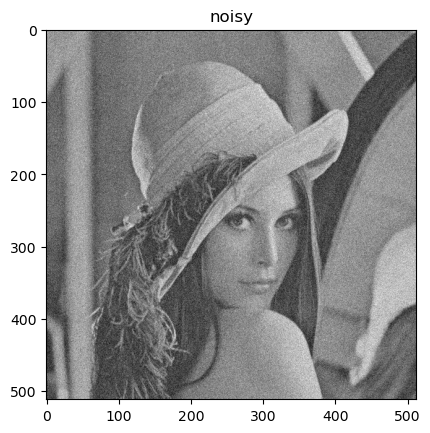

In [2]:
# settings
sigma = 20
img_noisy = img + sigma*  np.random.randn(img.shape[0], img.shape[1])
plt.imshow(img_noisy, cmap = 'gray')
plt.title('noisy')

In [3]:

dct_kwargs = {
    'is_real': 1.0, # complex-valued curvelets
    'finest': 2.0, # use wavelets at the finest level
    'nbscales': 6.0,
    'nbangles_coarse': 16.0}


curvelet_system, curvelet_coeff_dim = get_curvelet_system(
    img_noisy.shape[0],
    img_noisy.shape[1],
    dct_kwargs)

curvelet_support_size =  np.prod(np.array(curvelet_coeff_dim), 1)

In [6]:
dct_kwargs = {
    'is_real': 1.0, # complex-valued curvelets
    'finest': 2.0, # use wavelets at the finest level
    'nbscales': 4.0,
    'nbangles_coarse': 16.0}

curvelet_system, curvelet_coeff_dim = get_curvelet_system(
    256,
    256,
    dct_kwargs)

curvelet_support_size =  np.prod(np.array(curvelet_coeff_dim), 1)

np.save('curvelet_system_256.npy', curvelet_system)

np.save('curvelet_support_size_256.npy', curvelet_support_size)

In [21]:
curvelet_norms = np.sqrt(np.sum(np.abs(curvelet_system) ** 2, (1,2) ))


coeffs = numpy_fdct_2d(img_noisy, curvelet_system)


coeffs_thres = copy.copy(coeffs)

for s in range(1, coeffs.shape[0]):
  thresh = 3*sigma + sigma*(s == coeffs.shape[0])
  thresh *= 0.002
  coeffs_thres[s, ...] = coeffs_thres[s, ...] * (
      np.abs(coeffs_thres[s, ...]) > thresh * curvelet_norms[s] )


decomp = numpy_ifdct_2d(coeffs_thres, curvelet_system, curvelet_support_size )

recon = decomp.sum(0).real

print(psnr(img, recon))


30.29171051015798


Text(0.5, 1.0, 'ground-truth')

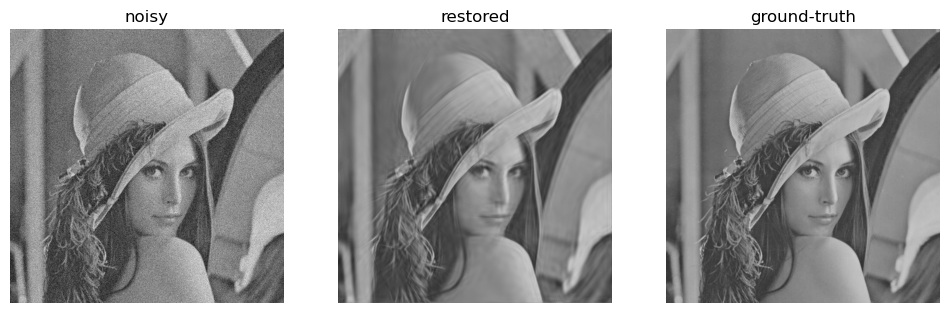

In [24]:

from diffcurve.plot_utils import plot_images, remove_frame


_, axes = plot_images([img_noisy.T, recon.T, img.T], cbar='none', cmap='gray',
                       fig_size = (12, 12))

[remove_frame(ax) for ax in axes.flatten()]

axes[0].set_title('noisy')
axes[1].set_title('restored')
axes[2].set_title('ground-truth')


